In [1]:
import argparse
import copy
import os
import sys

# Libs and helpers
from collections import OrderedDict

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.utils.tf_utils import tf_project_to_comp, tf_abs, tf_unitary_overlap
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *

tf.config.run_functions_eagerly(True)

2022-05-19 12:32:03.046094: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 12:32:03.046156: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"

=========== WARNING: no output directory specified ============


In [15]:
qubit_levels = [4, 4]
qubit_frequencies = [5e9, 4.5e9]
anharmonicities = [-300e6, -200e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = [50e-3, 50e-3]

In [16]:
# labels for all states
level_labels = []
level_labels_with_leakage = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 3 or j > 3:
            level_labels.append(None)
        else:
            level_labels.append(f"{i},{j}")
        level_labels_with_leakage.append(f"{i},{j}")

for i,l in enumerate(level_labels):
    print(i, l, level_labels_with_leakage[i])

0 0,0 0,0
1 0,1 0,1
2 0,2 0,2
3 0,3 0,3
4 1,0 1,0
5 1,1 1,1
6 1,2 1,2
7 1,3 1,3
8 2,0 2,0
9 2,1 2,1
10 2,2 2,2
11 2,3 2,3
12 3,0 3,0
13 3,1 3,1
14 3,2 3,2
15 3,3 3,3


In [17]:
# find energy eigenvalues and eigenvectors
qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                      t2stars, qubit_temps)
model = Mdl(qubits, [])
model.set_lindbladian(False)
model.set_dressed(False)
model.set_FR(False)
H = model.get_Hamiltonian().numpy()
evals,evecs = scipy.linalg.eig(H)
evals = evals.real / (2 * np.pi)
print(evals, len(evals))

[0.00e+00 4.50e+09 8.80e+09 1.29e+10 5.00e+09 9.50e+09 1.38e+10 1.79e+10
 9.70e+09 1.42e+10 1.85e+10 2.26e+10 1.41e+10 1.86e+10 2.29e+10 2.70e+10] 16


In [18]:
#energies = H.diagonal().real / (2*np.pi)
#labels = []
#for i in range(qubit_levels[0]):
#    for j in range(qubit_levels[1]):
#        idx = i * qubit_levels[0] + j
#        labels.append(f"{i},{j}")
#        print(labels[idx], energies[idx])
#indices = np.argsort(energies)

# find labels corresponding to states
stateEnergies = []
stateLabels = []
for i, x in enumerate(level_labels_with_leakage):
    #if level_labels[i] is not None:
    energy = evals[i]
    stateEnergies.append(energy)
    stateLabels.append(x)

for i in range(len(stateEnergies)):
    print(i, stateLabels[i], stateEnergies[i])

0 0,0 0.0
1 0,1 4500000000.0
2 0,2 8800000000.000002
3 0,3 12899999999.999998
4 1,0 5000000000.0
5 1,1 9500000000.0
6 1,2 13800000000.000004
7 1,3 17900000000.0
8 2,0 9700000000.000002
9 2,1 14200000000.000002
10 2,2 18500000000.000004
11 2,3 22600000000.000004
12 3,0 14099999999.999996
13 3,1 18599999999.999996
14 3,2 22900000000.0
15 3,3 26999999999.999996


In [19]:
# list all transitions
sortedEnergiesLabels = sorted(zip(stateEnergies, stateLabels), key=lambda x: x[0])
transitionEnergies = []
transitionLabels = []
transitionStateIndices = []
for i in range(len(sortedEnergiesLabels)):
    for j in range(len(sortedEnergiesLabels)):
        if i != j:
            E = sortedEnergiesLabels[j][0] - sortedEnergiesLabels[i][0]
            if E > 0:
                transitionEnergies.append(E)
                transitionLabels.append(sortedEnergiesLabels[i][1] + " - " + sortedEnergiesLabels[j][1])
                transitionStateIndices.append((i, j))

for i in range(len(transitionEnergies)):
    print(i, transitionLabels[i], transitionStateIndices[i], transitionEnergies[i])

0 0,0 - 0,1 (0, 1) 4500000000.0
1 0,0 - 1,0 (0, 2) 5000000000.0
2 0,0 - 0,2 (0, 3) 8800000000.000002
3 0,0 - 1,1 (0, 4) 9500000000.0
4 0,0 - 2,0 (0, 5) 9700000000.000002
5 0,0 - 0,3 (0, 6) 12899999999.999998
6 0,0 - 1,2 (0, 7) 13800000000.000004
7 0,0 - 3,0 (0, 8) 14099999999.999996
8 0,0 - 2,1 (0, 9) 14200000000.000002
9 0,0 - 1,3 (0, 10) 17900000000.0
10 0,0 - 2,2 (0, 11) 18500000000.000004
11 0,0 - 3,1 (0, 12) 18599999999.999996
12 0,0 - 2,3 (0, 13) 22600000000.000004
13 0,0 - 3,2 (0, 14) 22900000000.0
14 0,0 - 3,3 (0, 15) 26999999999.999996
15 0,1 - 1,0 (1, 2) 500000000.0
16 0,1 - 0,2 (1, 3) 4300000000.000002
17 0,1 - 1,1 (1, 4) 5000000000.0
18 0,1 - 2,0 (1, 5) 5200000000.000002
19 0,1 - 0,3 (1, 6) 8399999999.999998
20 0,1 - 1,2 (1, 7) 9300000000.000004
21 0,1 - 3,0 (1, 8) 9599999999.999996
22 0,1 - 2,1 (1, 9) 9700000000.000002
23 0,1 - 1,3 (1, 10) 13400000000.0
24 0,1 - 2,2 (1, 11) 14000000000.000004
25 0,1 - 3,1 (1, 12) 14099999999.999996
26 0,1 - 2,3 (1, 13) 18100000000.000004
2

In [20]:
def getEnergies(couplingStrength: float) -> np.array:
    # Initialise the qubits and drive lines
    qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                          t2stars, qubit_temps)
    coupling = createChainCouplings([couplingStrength], qubits)

    # Create the model
    model = Mdl(qubits, coupling)
    model.set_lindbladian(False)
    model.set_dressed(False)
    model.set_FR(False)

    # all energy levels with labels
    H = model.get_Hamiltonian().numpy()
    evals,evecs = scipy.linalg.eig(H)
    return evals.real / (2 * np.pi)

In [21]:
couplings = np.linspace(0, 50e6, 100)
#allEnergies = getEnergies(couplings[0])
#allEnergies = np.reshape(allEnergies, (25,1))
allEnergies = np.empty(shape=(16,0))
for coupling in couplings:
    print(coupling)
    energies = getEnergies(coupling)
    energies = np.sort(energies)
    allEnergies = np.append(allEnergies, np.reshape(energies, (16,1)), axis=1)

0.0
505050.50505050505
1010101.0101010101
1515151.5151515151
2020202.0202020202
2525252.525252525
3030303.0303030303
3535353.5353535353
4040404.0404040404
4545454.545454545
5050505.05050505
5555555.555555556
6060606.060606061
6565656.565656565
7070707.070707071
7575757.575757576
8080808.080808081
8585858.585858585
9090909.09090909
9595959.595959596
10101010.1010101
10606060.606060605
11111111.111111112
11616161.616161617
12121212.121212121
12626262.626262626
13131313.13131313
13636363.636363637
14141414.141414141
14646464.646464646
15151515.151515152
15656565.656565657
16161616.161616161
16666666.666666666
17171717.17171717
17676767.676767677
18181818.18181818
18686868.686868686
19191919.191919193
19696969.696969695
20202020.2020202
20707070.70707071
21212121.21212121
21717171.717171717
22222222.222222224
22727272.727272727
23232323.232323233
23737373.737373736
24242424.242424242
24747474.74747475
25252525.25252525
25757575.757575758
26262626.26262626
26767676.767676767
27272727.272727

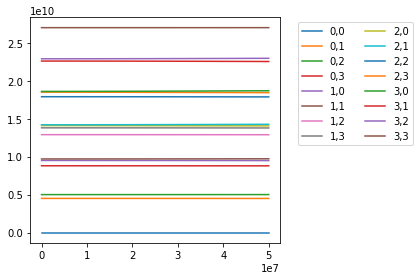

In [22]:
plt.figure()
y = allEnergies.T
#plt.plot(couplings, y, '.', color='black', markersize=1)
plt.plot(couplings, y)
plt.legend(
    stateLabels,
    ncol=int(np.ceil(16 / 15)),
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
)
plt.tight_layout()
#plt.savefig('energies-couplings.svg')
plt.show()

0,1 - 1,0 499999999.9999981 502542879.298399
0,2 - 1,1 700000000.0 697408886.7530918
0,2 - 2,0 899999999.9999943 908043271.8225269
1,1 - 2,0 199999999.99999428 210634385.06943512
0,3 - 1,2 900000000.0000286 897555180.0946827
0,3 - 3,0 1200000000.0000038 1186713303.13348
0,3 - 2,1 1300000000.0000267 1323636003.6991043
1,2 - 3,0 299999999.9999752 289158123.0387974
1,2 - 2,1 399999999.9999981 426080823.6044216
3,0 - 2,1 100000000.00002289 136922700.56562424
1,3 - 2,2 599999999.9999657 581727855.2501259
1,3 - 3,1 700000000.0000076 736792373.8893623
2,2 - 3,1 100000000.00004196 155064518.63923645
2,3 - 3,2 299999999.9999733 336093847.982811


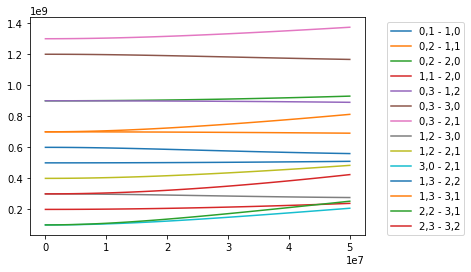

In [27]:
#selectedTransitions = [1, 26, 72, 133] #[1, 26, 49, 94, 112, 184] #[67, 101]#1, 17, 31, 58
selectedTransitions = list(range(len(transitionStateIndices)))

plt.figure()
for t in selectedTransitions:
    index = transitionStateIndices[t]
    data1 = allEnergies[index[0]]
    data2 = allEnergies[index[1]]
    diff = data2 - data1
    if diff[0] < 2e9:
        plt.plot(couplings, diff, label=transitionLabels[t])
        print(transitionLabels[t], diff[0], diff[int(len(diff)/2)])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()